In [1]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/kds/1sem/ditw/ditw_project')

In [3]:
!pip install sentence_transformers
!pip install hdbscan
!pip install umap-learn
!pip install matplotlib
!pip install pandas

     |████████████████████████████████| 78 kB 3.2 MB/s 
     |████████████████████████████████| 3.1 MB 12.5 MB/s 
     |████████████████████████████████| 3.3 MB 40.6 MB/s 
     |████████████████████████████████| 1.2 MB 37.9 MB/s 
     |████████████████████████████████| 61 kB 521 kB/s 
     |████████████████████████████████| 596 kB 48.6 MB/s 
     |████████████████████████████████| 895 kB 58.0 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=c41d3da404394882d0e08fb01e539cd8e398d6ee4c5af3ae9115e334974c392f
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 6.4 MB 4.0 MB/s 
  Installing build dependencies ... done
  Getting requirements

In [19]:
from src.json_utils import read_json, read_jsonl
from sentence_transformers import SentenceTransformer
import hdbscan
import umap
import matplotlib.pyplot as plt
import pandas as pd
from src.preprocessing import *
from sklearn.cluster import DBSCAN
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import TweetTokenizer

In [5]:
data = read_jsonl('data/dkpol_tweets.jsonl')
df = pd.DataFrame(data)
df[df['in_reply_to_user_id'].isna()]
df.created_at = pd.to_datetime(df.created_at)
sub = df[['created_at', 'text', 'entities']].groupby(df.created_at.dt.to_period("M")).head(350)
#sub = df.groupby(df.created_at.dt.to_period("M")).head(100)
df = sub
text = df['text']
len(df)

Reading data/dkpol_tweets.jsonl


/usr/local/lib/python3.7/dist-packages/pandas/core/arrays/datetimes.py:1092: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  UserWarning,


7350

In [6]:
text_without_processing = replace_url(df['text'], replacement = 'URL')

In [7]:
encoder = SentenceTransformer('Maltehb/danish-bert-botxo')
embeddings = encoder.encode(text_without_processing, show_progress_bar=True)

Downloading:   0%|          | 0.00/512 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.31k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/662 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.38k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/4.63M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/445M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/72.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/253k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/Maltehb_danish-bert-botxo were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/230 [00:00<?, ?it/s]

In [8]:
umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=10, 
                            metric='cosine').fit_transform(embeddings)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [9]:
cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(umap_embeddings)

In [12]:
print(Counter(cluster.labels_))

Counter({18: 6319, 16: 365, 5: 164, 14: 69, 1: 56, 10: 50, 4: 47, -1: 37, 9: 28, 6: 26, 12: 25, 11: 24, 3: 22, 15: 22, 2: 21, 7: 21, 0: 16, 13: 14, 8: 13, 17: 11})


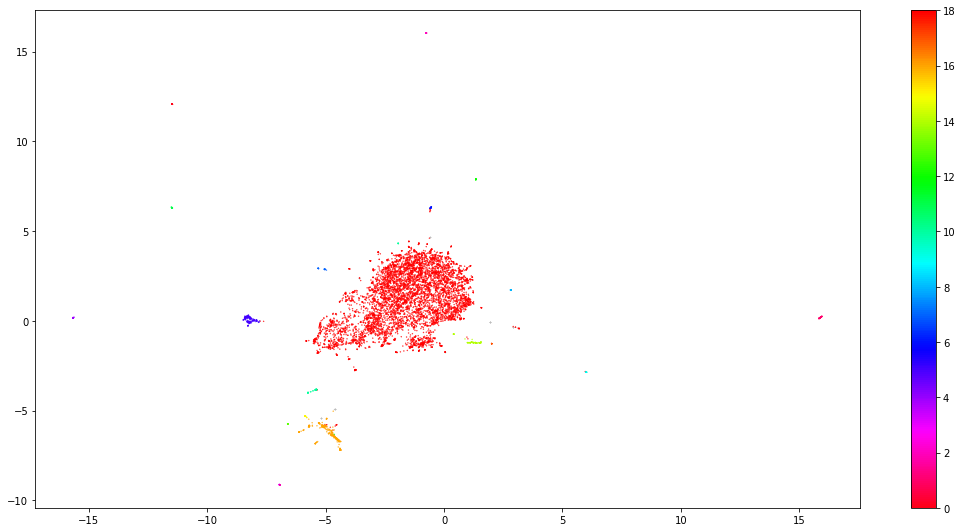

In [13]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [20]:
with open('data/danish_stopwords.txt') as stop_file:
  stopwords = [word.strip() for word in stop_file.readlines()]

def remove_stopwords(token: str) -> str:
    return token if token not in stopwords else ''

def remove_newlines(text: str) -> str:
    return re.sub(r'\n+', ' ', text)

def remove_numbers(text, str) -> str:
    return re.sub(r'\d+', '', text)


def normalize_spaces(text: str) -> str:
    return re.sub(r'\s{2,}', ' ', text)

import string 
    
def remove_punctuation(text: str) -> str:
    """BUT DO NOT REMOVE HASHTAGS OR MENTIONS"""
    regexp = re.compile(r'([#@]\w+)')
    return text if regexp.search(text) else re.sub(f'[{string.punctuation}]', '', text)


def is_website_token(token: str) -> str:
    if token[:4] == 'http':
        return ''
    else:
        return token

def remove_standalone_numbers(text: str) -> str:
    return re.sub(f'(?<!\S)\d+(?!\S)', '', text)

def split_by_space(text: str) -> List[str]:
    return text.split(' ')

In [21]:
tweet_tokenizer = TweetTokenizer().tokenize
tokenizer = TweetTokenizer()

text_list = list(text.values)

tokenized_text = [[token for token in tokenizer.tokenize(i)] for i in text_list]

print(tokenized_text[:2])

preprocessing_func = [remove_punctuation, str.lower, is_website_token, remove_stopwords, remove_standalone_numbers]

all_tokenizer_text = []

for token_text in tokenized_text:
    post_processed = []
    for token in token_text:
        for function in preprocessing_func:
            token = function(token)
        if token != '':
            post_processed.append(token)
    all_tokenizer_text.append(' '.join(post_processed))

print(all_tokenizer_text[:2])
print(len(all_tokenizer_text))

[['Det', 'er', 'på', 'tide', 'køreprøver', 'kommer', 'i', 'konkurrence', 'og', 'på', 'private', 'hænder', '.', 'Ligesom', 'med', 'bilsyn', '.', 'Væk', 'med', 'ventetider', 'og', 'styrket', 'kvaliteten', '.', '#dkpol', 'https://t.co/YfmAvrkwQu'], ['Min', 'klumme', 'i', '@berlingske', '"', 'I', 'utallige', 'år', ',', 'især', 'op', 'til', 'valgkampe', ',', 'har', 'der', 'været', 'fokus', 'på', 'jobcentrene', 'og', 'beskæftigelsesindsatsen', '.', 'Guld', 'og', 'grønne', 'skove', 'er', 'lovet', ',', 'men', 'alt', 'er', 'lige', 'så', 'gudsforladt', 'og', 'dysfunktionelt', 'som', 'altid', '.', '"', '#dkpol', '#dkmedier', 'https://t.co/GsZjYE2rGl']]
['tide køreprøver konkurrence private hænder bilsyn væk ventetider styrket kvaliteten #dkpol', 'klumme @berlingske utallige år især valgkampe fokus jobcentrene beskæftigelsesindsatsen guld grønne skove lovet gudsforladt dysfunktionelt #dkpol #dkmedier']
7350


In [22]:
print(len(all_tokenizer_text))
print(len(list(text.values)))

7350
7350


In [ ]:
docs_df = pd.DataFrame(all_tokenizer_text , columns=["Doc"])
docs_df['Original Docs'] = list(text.values)
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

### Tf-idf on docs from each cluster

In [ ]:
docs_per_topic.loc[docs_per_topic['Topic'] == 17]['Doc'].values[0][:200]

'tide køreprøver konkurrence private hænder bilsyn væk ventetider styrket kvaliteten #dkpol klumme @berlingske utallige år især valgkampe fokus jobcentrene beskæftigelsesindsatsen guld grønne skove lov'

In [ ]:
docs_df.loc[docs_df['Topic'] == 17].sample(20)['Original Docs'].values

array(['Flemming Chr. Nielsen på Facebook #dkpol #dkmedier https://t.co/es0YvL7AIs',
       '@J_Seb_ Danske dommere er slappe som en karklud\n\nIS-krigerne bliver løsladt eller får en latterlig lav straf så snart de kommer til DK\n\nDerefter er det fri bolig sociale ydelser og familiesammenføring hele vejen\n\nTag jer sammen #dkpol',
       'Jeg er ik helt enig, men vi skal se os godt for i disse måneder. Ekstrem højre er ekstremt aktive også internationalt #dkpol https://t.co/gSAMq06uNB',
       '@Pia_Kjaersgaard Næh, Pia. Egede tvangskristnede inuitter. Nøjagtig det samme du frygter med tvangsislamisering i Danmark ...\n#dkpol',
       '@Susanne_Zimmer_ Altså i #dkpol går det mega fint at gøre hvad som helst modsat - hvem skulle dog standse det? Er der nogen der går på gaden i demonstration, ses høtyve eller fakler, gabestokke eller guillotiner? Er selv meningsmålinger ikke nærmest understøttende vanvid, destruktion og had?',
       'Vi er begejstrede for mange ting i ny udviklingspo

In [27]:
def c_tf_idf(documents, m, ngram_range=(1, 3)):
    count = CountVectorizer(tokenizer = split_by_space, stop_words = None, ngram_range = (1,1)).fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
#tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

In [25]:
def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

#top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
#top_n_words
#topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

In [ ]:
len(top_n_words)
top_n_words[15]

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

for i in range(8):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = docs_df.groupby(['Topic']).count().sort_values("Doc", ascending=False).reset_index()
    topic_to_merge = topic_sizes.iloc[-1].Topic
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    docs_df.loc[docs_df.Topic == topic_to_merge, "Topic"] = topic_to_merge_into
    old_topics = docs_df.sort_values("Topic").Topic.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    docs_df.Topic = docs_df.Topic.map(map_topics)
    docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

    # Calculate new topic words
    m = len(data)
    tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

In [ ]:
# Get topic ids of alle clusters with more than 200 documents
topic_subset = topic_sizes[topic_sizes.Doc > 100]
topic_subset = list(topic_subset.Topic.values)

In [ ]:
print(topic_subset)
len(top_n_words)
print(topic_sizes.head(20))
print(top_n_words.keys())

### Reduce large clusters

Counter({38: 1838, 34: 812, 20: 677, 28: 362, 30: 361, -1: 354, 15: 339, 27: 289, 10: 260, 14: 123, 19: 122, 11: 100, 37: 61, 24: 42, 6: 42, 25: 39, 36: 38, 17: 36, 18: 35, 31: 35, 22: 32, 12: 30, 29: 25, 23: 22, 9: 22, 5: 20, 8: 18, 33: 18, 21: 16, 26: 16, 35: 16, 4: 14, 3: 14, 0: 14, 7: 14, 2: 14, 32: 13, 16: 13, 13: 12, 1: 11})


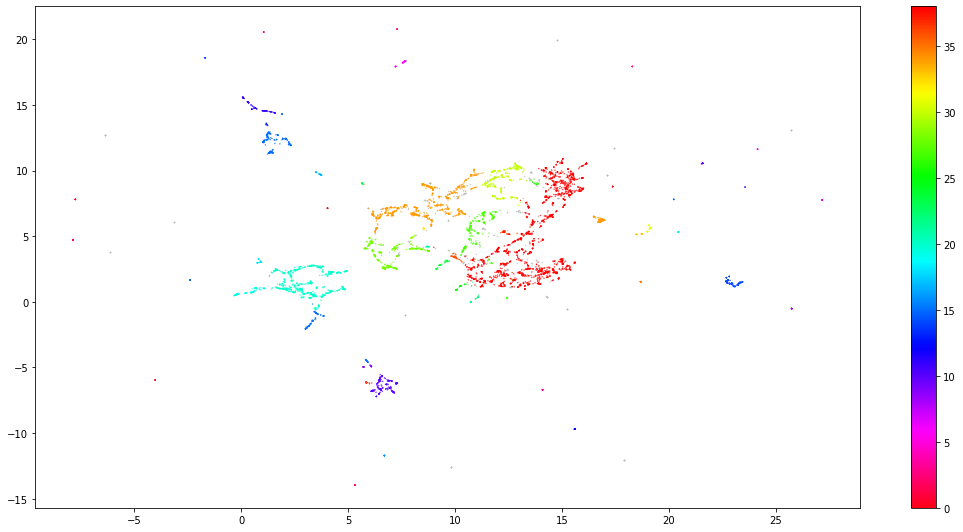

In [23]:
# Reduce large clusters

# Get large cluster idx
large_cluster_idx = [idx for idx, label in enumerate(cluster.labels_) if label == 18]
large_cluster_embeddings = umap_embeddings[large_cluster_idx,:]

# Reduce dim
large_umap_embeddings = umap.UMAP(n_neighbors=15, 
                            n_components=5, 
                            metric='cosine').fit_transform(large_cluster_embeddings)


large_cluster = hdbscan.HDBSCAN(min_cluster_size=10,
                          metric='euclidean',                      
                          cluster_selection_method='eom',
                          cluster_selection_epsilon=0.5).fit(large_umap_embeddings)

print(Counter(large_cluster.labels_))

# Prepare data
large_umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(large_cluster_embeddings)
large_result = pd.DataFrame(large_umap_data, columns=['x', 'y'])
large_result['labels'] = large_cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(15, 7.5))
outliers = large_result.loc[large_result.labels == -1, :]
clustered = large_result.loc[large_result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.15)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.15, cmap='hsv_r')
plt.colorbar()
plt.tight_layout()

In [28]:
docs_df = pd.DataFrame([all_tokenizer_text[i] for i in large_cluster_idx] , columns=["Doc"])
docs_df['Original Docs'] = [list(text.values)[i] for i in large_cluster_idx]
docs_df['Topic'] = large_cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(data))

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=30)
top_n_words
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  "The parameter 'token_pattern' will not be used"
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Topic,Size
39,38,1838
35,34,812
21,20,677
29,28,362
31,30,361
0,-1,354
16,15,339
28,27,289
11,10,260
15,14,123


In [35]:
docs_df.head()

,Doc,Original Docs,Topic,Doc_ID
0,tide køreprøver konkurrence private hænder bil...,Det er på tide køreprøver kommer i konkurrence...,-1,0
1,klumme @berlingske utallige år især valgkampe ...,"Min klumme i @berlingske ""I utallige år, især...",30,1
2,@stinekbh ret derimod fællestræk mobber #dkpol,@StineKbh Det har du ret i. Derimod er der fle...,38,2
3,pige tæt dø pga farlige legetøjsmagneter købt ...,Denne lille pige var tæt på at dø pga farlige ...,28,3
4,morgen gruppe folketingsmedlemmer tager warsza...,I morgen er vi en gruppe folketingsmedlemmer d...,34,4


In [40]:
top_n_words[14]

[('#dkpol', 0.5172926973203087),
 ('#dkmedier', 0.1677657852550967),
 ('@europabev', 0.15332062827324086),
 ('🤔', 0.1379668312946638),
 ('#eupol', 0.09553183990070943),
 ('🏼', 0.0916657419937732),
 ('#covid19', 0.08413571153254092),
 ('#dkgreen', 0.08070978853783661),
 ('🙄', 0.07617431363673006),
 ('👏', 0.07484145463247431),
 ('yeah', 0.06542071387523135),
 ('#itpol', 0.06418043117595276),
 ('host', 0.06222341027492023),
 ('👍', 0.05788641364197715),
 ('🇺', 0.05670687819181595),
 ('#dkklima', 0.055039378477305854),
 ('\u2069', 0.05475162507917571),
 ('🇪', 0.05474985729078343),
 ('\u2066', 0.05420282813072698),
 ('😂', 0.05144708303376506),
 ('»', 0.048184681127221615),
 ('«', 0.04786821843582778),
 ('læs', 0.046731796091180396),
 ('#velfærd', 0.04666755770619017),
 ('be', 0.04419047701342639),
 ('@politikdr', 0.04419047701342639),
 ('of', 0.04346037066832091),
 ('#sundpol', 0.04305063300777006),
 ('tråd', 0.04282178320426986),
 ('#dkbiz', 0.040463729203146885)]